<a href="https://colab.research.google.com/github/Pinkysol/Learning/blob/main/Animals-10%2BAUTOKERAS%2BSTREAMLIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

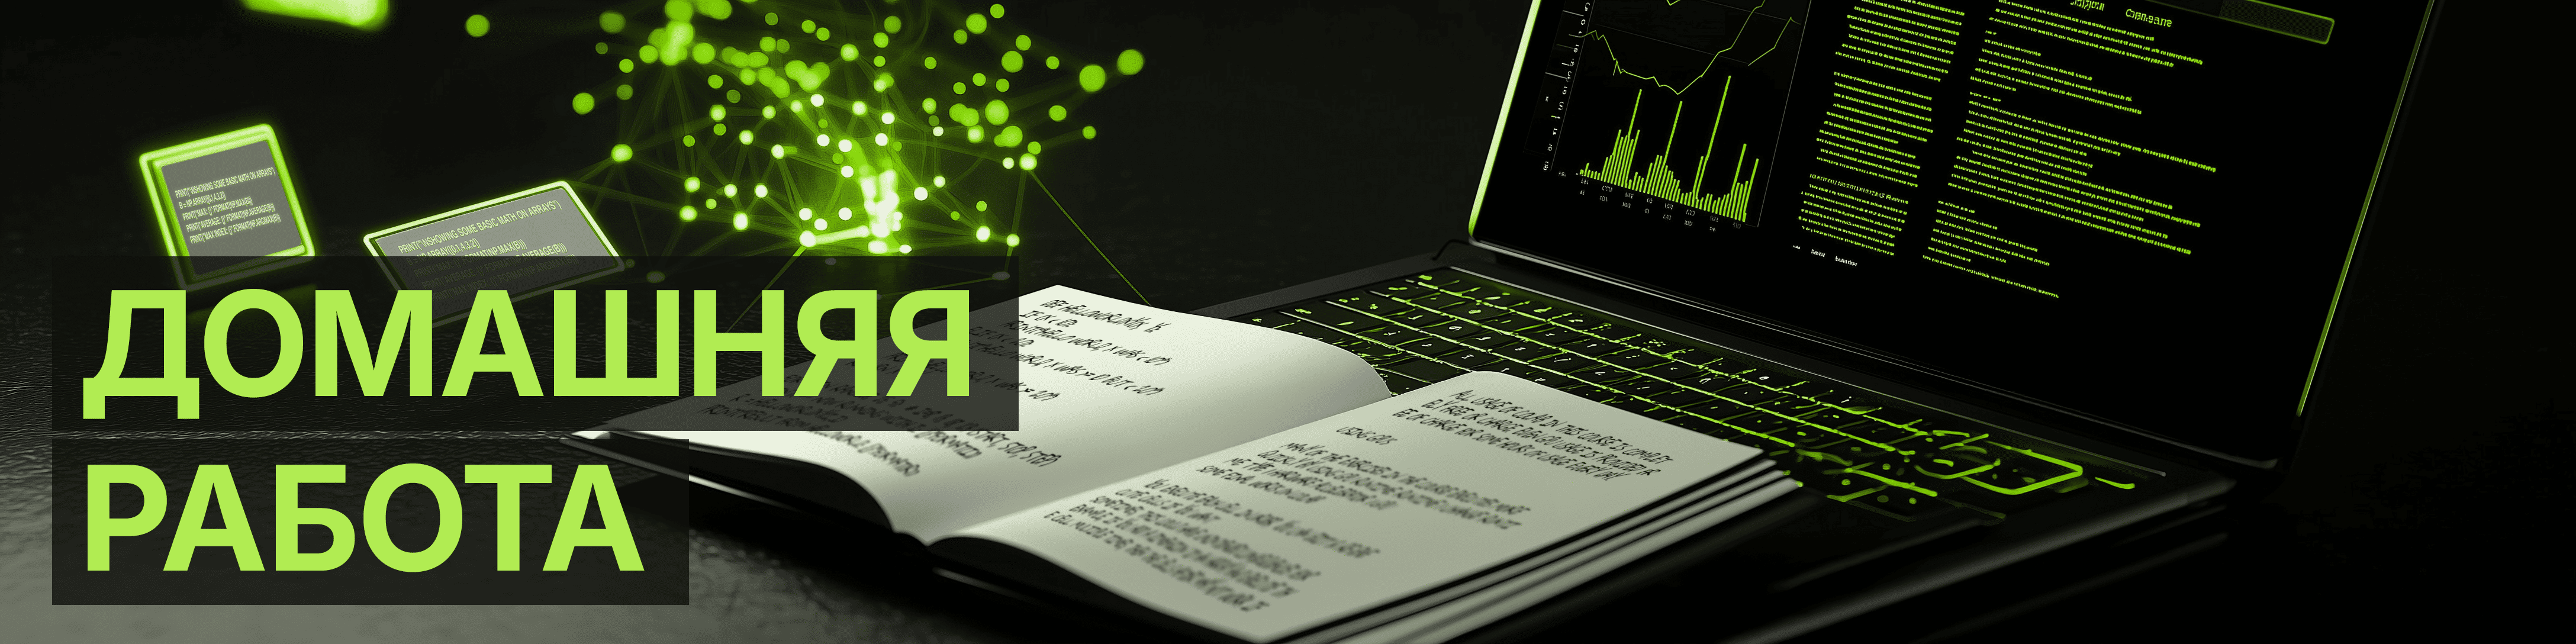

**Навигация по уроку**
1. [Инструменты создания web-интерфейсов](https://colab.research.google.com/drive/1JMj27rzWwL3r6jDqdxHv9Y3LiDgAEAvC)
2. [Создаем интерфейс на Streamlit](https://colab.research.google.com/drive/1THSgc9HQwUA2WfrmD8X7JR97huFSIjC3)
3. [Создание чат-бота на Gradio](https://colab.research.google.com/drive/1LLKuYCFLO-BpCj2PxtELXDP3qMXia8fK)
4. Домашняя работа

В домашней работе вам необходимо создать интерфейс к вашей модели нейронной сети, используя Streamlit (можно и Gradio). Для этого:

1. Определитесь, какую задачу будет решать ваша нейронная сеть.
2. Продумайте интерфейс взаимодействия с пользователем, какими параметрами модели пользователь будет управлять.
3. Обучите модель на любом публичном датасете или возьмите из любого предыдущего урока. Вспомните как происходит загрузка и выгрузка моделей в Keras.
4. Загрузите обученную модель в Colab с интерфейсом (деплой модели).
5. Создайте интерфейс для инференса вашей модели (для запросов к модели).
6. Изучите как происходит загрузка файлов для моделей с помощью Streamlit по [ссылке](https://docs.streamlit.io/develop/api-reference/widgets/st.file_uploader).
7. Добавьте в интерфейс возможность загрузки пользовательских данных для инференса. Это может быть текстовый файл, картинка, аудиофайл или др.
8. Выполнив задание, получите 3 балла.
9. Вы также можете получить дополнительные 2 балла, если реализуете в одном интерфейсе обучение модели и её инференс.

**Инференс** - это процесс исполнения обученных моделей машинного обучения для получения предсказаний на данных, поданных на вход модели.
Обычно нейронная сеть проходит три жизненных этапа: обучение, деплой и инференс. Инференсом называется непрерывная работа какой-либо нейронной сети на конечном устройстве.

**Деплой** - загрузка на сервер.

In [1]:
# Установка нужных библиотек
!pip install autokeras
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.7/122.7 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 87.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.2 MB/s eta 0:00:00


In [2]:
# Загрузка датасета https://www.kaggle.com/datasets/alessiocorrado99/animals10/data
!wget https://storage.yandexcloud.net/quiz-bucket-pinkysoul/Animals.zip
# Разархивируем датасет во временную папку 'dataset'
!unzip -qo "Animals.zip" -d ./dataset

--2025-05-15 12:23:26--  https://storage.yandexcloud.net/quiz-bucket-pinkysoul/Animals.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 296082403 (282M) [application/x-zip-compressed]
Saving to: ‘Animals.zip’

Animals.zip         100%[===================>] 282.37M  12.5MB/s    in 25s     

2025-05-15 12:23:52 (11.3 MB/s) - ‘Animals.zip’ saved [296082403/296082403]



In [3]:
# Импорт нужных библиотек
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
import autokeras as ak

# Создание переменной с адресом датасета
FILE_DIR = './dataset'
# Выбор и сортировка наименований папок, как наименований классов
class_names = sorted(os.listdir(FILE_DIR))
# Перечисление классов по индексам
class_to_index = {name: i for i, name in enumerate(class_names)}

In [4]:
x = []
y = []
# Выбор размера изображения, как 64x64 для меньшего использования ОЗУ, а так же выбор стандартного разрешения для приведения изображений, которые имеют другое разрешение
size = 64, 64
# Цикл выбора папок по классам
for class_name in class_names:
    # Содание пути ./dataset/{class_name}
    class_folder = os.path.join(FILE_DIR, class_name)
    # Условие, если по пути папка
    if os.path.isdir(class_folder):
        # Цикл выбора файлов в папках
        for filename in os.listdir(class_folder):
            # Условие, если имя файла заканчивается на .jpg, .jpeg или .png
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                # Чтение файла
                image = tf.io.read_file(os.path.join(class_folder, filename))
                # Декодирование изображения в тензор
                image = tf.image.decode_jpeg(image, channels=3)
                # Изменение размера изображения до 64x64
                image = tf.image.resize(image, size)
                # Добавление изображений и индексов классов
                x.append(image)
                y.append(class_to_index[class_name])

In [5]:
# Создание тренировочной, тестовой и валидационной выборок
X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
# Создание датасетов из списков
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
# Очистка памяти от использованных переменных
del X_train, X_temp, y_train, y_temp, X_val, X_test, y_val, y_test, x, y

In [6]:
# Обучение автоматической модели на 10 эпохах
clf = ak.ImageClassifier(overwrite=True, max_trials=1)
result_training = clf.fit(train_dataset, epochs = 10, validation_data = val_dataset)
# Получение лучшей модели
model = clf.export_model()
# Сохранение модели
model.save("model_autokeras.keras")

Trial 1 Complete [00h 00m 54s]
val_loss: 0.6482759714126587

Best val_loss So Far: 0.6482759714126587
Total elapsed time: 00h 00m 54s
Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - accuracy: 0.4669 - loss: 1.4034 - val_accuracy: 0.6927 - val_loss: 0.8360
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7055 - loss: 0.7915 - val_accuracy: 0.7324 - val_loss: 0.7286
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7838 - loss: 0.6003 - val_accuracy: 0.7376 - val_loss: 0.7413
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8177 - loss: 0.4863 - val_accuracy: 0.7226 - val_loss: 0.8030
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8521 - loss: 0.4009 - val_accuracy: 0.7451 - val_loss: 0.7246
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8841 - loss: 0.3273 - val_accuracy: 0.7406 - val_loss: 0.7765
Epoch 7/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8987 - loss: 0.2791 - va

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
%%writefile main.py
import streamlit as st
import tensorflow as tf
import keras

# Создание виджета для загрузки файла
uploaded_file = st.file_uploader("Изображение бабочки, курицы, собаки, слона или овцы", ["jpg", "jpeg", "png"], False)
# Условие, проверка заполнения выбора файла
if uploaded_file is not None:

  size = 64, 64
  # Вывод выбранного изображения
  st.image(uploaded_file.getvalue(), caption="Выбранное изображение")
  # Декодирование изображения в тензор
  image = tf.image.decode_jpeg(uploaded_file.getvalue(), channels=3)
  # Изменение размера изображения до 64x64
  image = tf.image.resize(image, size)
  # Добавление измерения для предсказания
  image = tf.reshape(image, [1, 64, 64, 3])
  # Загрузка модели
  model = keras.models.load_model("model_autokeras.keras")
  # Предсказание класса моделью
  prediction = model.predict(image)
  # Создание списка наименований классов
  class_name = ['бабочка', 'курица', 'собака', 'слон', 'овца']
  # Выбор значения с высшей вероятностью
  predicted_value = prediction[0].argmax(axis=0)
  # Вывод названия выбранного класса
  st.write("Животное с вашей картинки это ", class_name[predicted_value])

Overwriting main.py


In [27]:
!streamlit run main.py --server.address=localhost >/content/logs.txt & ssh -o "StrictHostKeyChecking no" -R 80:localhost:8501 serveo.net

Forwarding HTTP traffic from https://a19e7f25d54b45eb9d71b581641fe81a.serveo.net
HTTP request from 5.77.4.122 to https://a19e7f25d54b45eb9d71b581641fe81a.serveo.net/
HTTP request from 5.77.4.122 to https://a19e7f25d54b45eb9d71b581641fe81a.serveo.net/static/media/SourceSansPro-Regular.DZLUzqI4.woff2
HTTP request from 5.77.4.122 to https://a19e7f25d54b45eb9d71b581641fe81a.serveo.net/static/media/SourceSansPro-SemiBold.sKQIyTMz.woff2
HTTP request from 5.77.4.122 to https://a19e7f25d54b45eb9d71b581641fe81a.serveo.net/static/media/SourceSansPro-Bold.-6c9oR8J.woff2
HTTP request from 5.77.4.122 to https://a19e7f25d54b45eb9d71b581641fe81a.serveo.net/static/css/index.DqDwtg6_.css
HTTP request from 5.77.4.122 to https://a19e7f25d54b45eb9d71b581641fe81a.serveo.net/static/js/index.C1z8KpLA.js
HTTP request from 5.77.4.122 to https://a19e7f25d54b45eb9d71b581641fe81a.serveo.net/_stcore/health
HTTP request from 5.77.4.122 to https://a19e7f25d54b45eb9d71b581641fe81a.serveo.net/_stcore/host-config
HTTP 

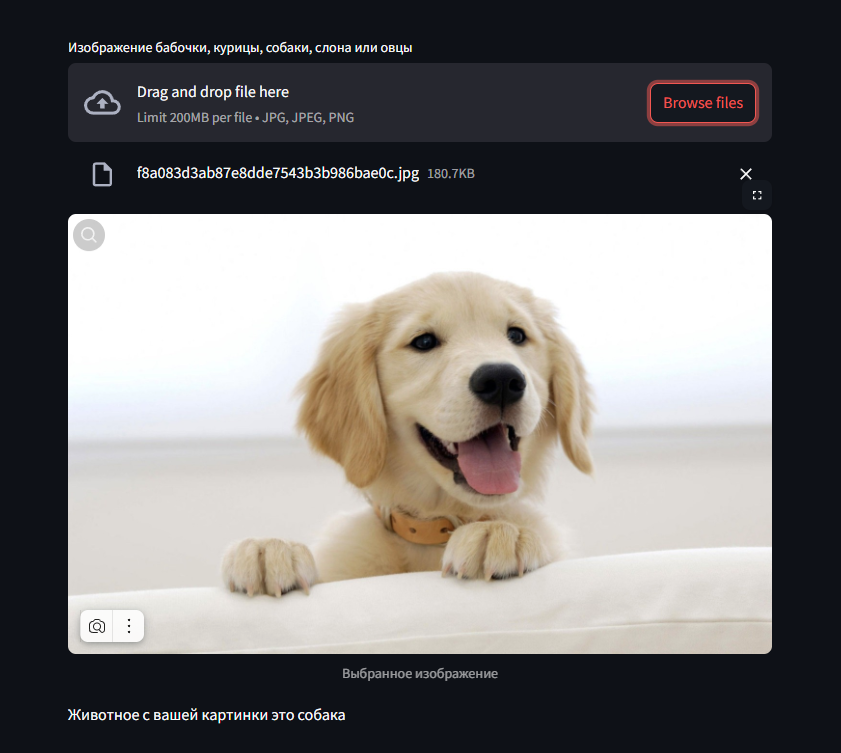

Выше приведено изображение, на котором показан результат работы данного инференса